# Kaggle Titanic Competition

We'll build a pipeline of functions for making predictions about passengers who survived based on the data provided in the [Kaggle Titanic competition](https://www.kaggle.com/competitions/titanic/leaderboard#). Then we'll submit our results to see how well our model performed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Loading and processing the data

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
def process_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for c in ['Age_categories','Fare_categories','Title','Cabin_type','Sex']:
        df = create_dummies(df,c)
    return df

In [6]:
train2 = process_df(train)
holdout2 = process_df(holdout)

In [7]:
holdout2.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,Sex_female,Sex_male
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,0,0,1,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,0,0,1,1,0


#### Exploring more of the data

In [8]:
train[['SibSp','Parch']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   SibSp   891 non-null    int64
 1   Parch   891 non-null    int64
dtypes: int64(2)
memory usage: 14.0 KB


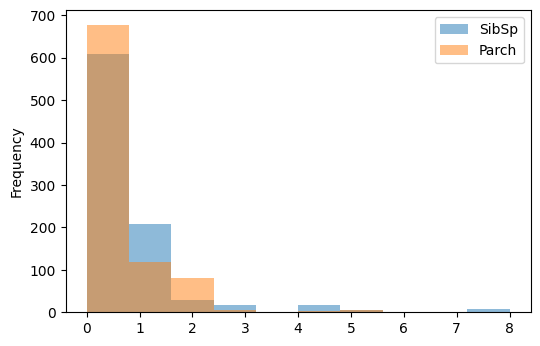

In [9]:
train[['SibSp','Parch']].plot.hist(alpha=0.5)

<ipython-input-10-032a89ad0a43>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



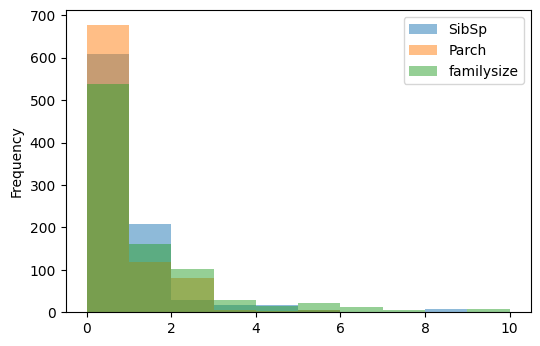

In [10]:
explore = train[['SibSp','Parch','Survived']]
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
for_plotting = explore.drop('Survived',axis=1)
for_plotting.plot.hist(alpha=0.5)
# plt.xticks(range(11))
plt.show()

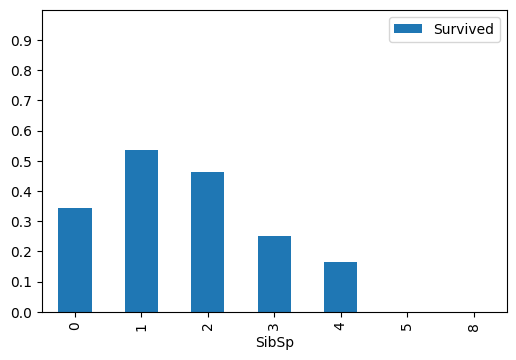

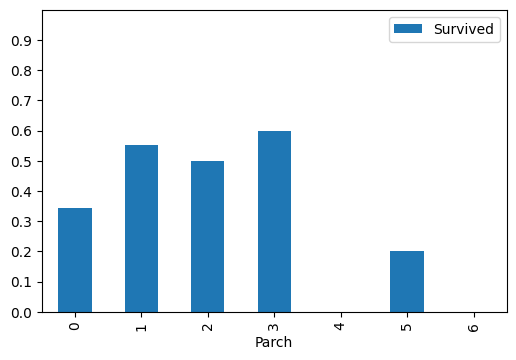

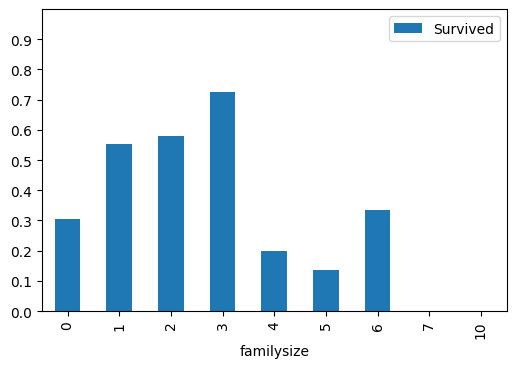

In [11]:
for col in for_plotting.columns:
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
#     plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

### Engineering new features

In [12]:
# defining a function to create a new feature based on family members
def family(df):
    df['familysize'] = df[["SibSp","Parch"]].sum(axis=1)
    df['isalone'] = df['familysize'].apply(lambda x: 0 if x > 0 else 1)
    df = df.drop("familysize",axis=1)
    return df
        

In [13]:
train3 = family(train2)
holdout3 = family(holdout2)

In [14]:
train3.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1


### Feature Selection

In [15]:
def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    optimized_columns = all_X.columns[selector.support_]
    
    print(optimized_columns)
    return optimized_columns

In [16]:
# Selecting the best columns from our training set
best_columns = select_features(train3)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'Sex_female', 'Sex_male', 'isalone'],
      dtype='object')


### Model selection and tuning

In [24]:
def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    
#     a list of dictionaries, each containing a model name, 
#     its estimator and a dictionary of hyperparameters
    models = [
        {"name": "LogisticRegression",
         "estimator": LogisticRegression(),
         "hyperparameters":{
             "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
        },
        {"name": "KNeighborsClassifier",
         "estimator": KNeighborsClassifier(),
         "hyperparameters":{
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
         }
        },
        {"name": "RandomForestClassifier",
         "estimator": RandomForestClassifier(),
         "hyperparameters":
         {
             "n_estimators": [4, 6, 9],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 5, 10],
             "max_features": ["log2", "sqrt"],
             "min_samples_leaf": [1, 5, 8],
             "min_samples_split": [2, 3, 5]
         }
        }
    ]
    for m in models:
        print(m["name"])
        grid = GridSearchCV(m["estimator"],param_grid=m["hyperparameters"],cv=10)
        grid.fit(all_X,all_y)
        m["best_params"] = grid.best_params_
        m["best_score"] = grid.best_score_
        m["best_model"] = grid.best_estimator_
        
        print("Best Score: {}".format(m["best_score"]))
        print("Best Parameters: {}\n".format(m["best_params"]))
    
    return models

In [25]:
result = select_model(train3,best_columns)

LogisticRegression


/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/system/env/python3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/dataquest/s

Best Score: 0.8204744069912608
Best Parameters: {'solver': 'lbfgs'}

KNeighborsClassifier
Best Score: 0.7767041198501874
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
Best Score: 0.8417727840199751
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9}



In [27]:
result

[{'name': 'LogisticRegression',
  'estimator': LogisticRegression(),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']},
  'best_params': {'solver': 'lbfgs'},
  'best_score': 0.8204744069912608,
  'best_model': LogisticRegression()},
 {'name': 'KNeighborsClassifier',
  'estimator': KNeighborsClassifier(),
  'hyperparameters': {'n_neighbors': range(1, 20, 2),
   'weights': ['distance', 'uniform'],
   'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'p': [1, 2]},
  'best_params': {'algorithm': 'brute',
   'n_neighbors': 5,
   'p': 1,
   'weights': 'uniform'},
  'best_score': 0.7767041198501874,
  'best_model': KNeighborsClassifier(algorithm='brute', p=1)},
 {'name': 'RandomForestClassifier',
  'estimator': RandomForestClassifier(),
  'hyperparameters': {'n_estimators': [4, 6, 9],
   'criterion': ['entropy', 'gini'],
   'max_depth': [2, 5, 10],
   'max_features': ['log2', 'sqrt'],
   'min_samples_leaf': [1, 5, 8],
   'min_samples_split': [2, 3, 5]},
  'best_params': {'

### Downloading predictions

In [34]:
def save_submission_file(model,columns,filename="submission.csv"):
    predictions = model.predict(holdout3[columns])
    submission = pd.DataFrame({'PassengerId':holdout3['PassengerId'],
                              'Survived':predictions})
    submission.to_csv(filename)

In [35]:
best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model,best_columns)

Other steps to try:
- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.